In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 13192882.10it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208940.39it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3905211.94it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5745683.07it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
class_names = train_data.class_to_idx

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

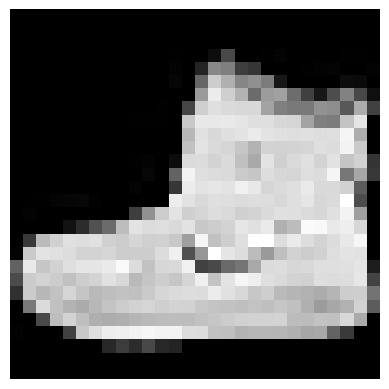

In [4]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze(), cmap="gray")
plt.axis(False)

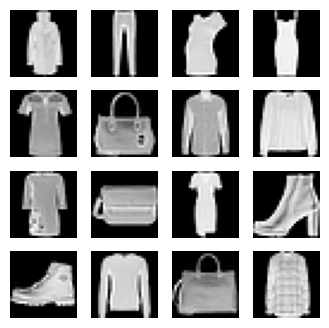

In [5]:
fig = plt.figure(figsize=(4, 4))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_index = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.axis(False)


In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

torch.Size([32, 1, 28, 28]) torch.Size([32])


(-0.5, 27.5, 27.5, -0.5)

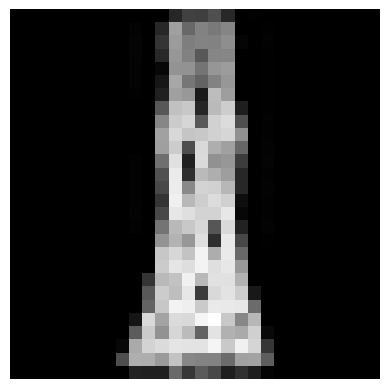

In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_features_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis(False)

# ModelV0

In [8]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [9]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Timer

In [11]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

In [12]:
start_time = timer()
# code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


In [13]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(epoch)
  train_loss = 0
  model_0.train()
  for batch, (X, y) in enumerate(train_dataloader):
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Progress: {(batch * len(X))/len(train_dataloader.dataset)}%")

  train_loss /= len(train_dataloader)

  model_0.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:4f} | Test loss: {test_loss:4f}, Test acc: {test_acc:4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

0
Progress: 0.0%
Progress: 0.21333333333333335%
Progress: 0.4266666666666667%
Progress: 0.64%
Progress: 0.8533333333333334%
Train loss: 0.590389 | Test loss: 0.509535, Test acc: 82.038738
1
Progress: 0.0%
Progress: 0.21333333333333335%
Progress: 0.4266666666666667%
Progress: 0.64%
Progress: 0.8533333333333334%
Train loss: 0.476332 | Test loss: 0.479890, Test acc: 83.196885
2
Progress: 0.0%
Progress: 0.21333333333333335%
Progress: 0.4266666666666667%
Progress: 0.64%
Progress: 0.8533333333333334%
Train loss: 0.455033 | Test loss: 0.476639, Test acc: 83.426518
Train time on cpu: 31.825 seconds


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

# ModelV1

In [16]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape,
                out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,
                out_features=output_shape),
      nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)


In [17]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

# Functionizing train and test loops

In [19]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")


In [20]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")


# ModelV1 Loop

In [21]:
train_time_start_on_gpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} -------------")
  train_step(model_1,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn)
  test_step(model_1,
            test_dataloader,
            loss_fn,
            accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 -------------
Train loss: 1.05878 | Train acc: 62.19
Test loss: 0.99506 | Test acc: 64.13
Epoch: 1 -------------
Train loss: 0.91331 | Train acc: 66.40
Test loss: 0.90508 | Test acc: 66.86
Epoch: 2 -------------
Train loss: 0.87982 | Train acc: 67.24
Test loss: 0.89476 | Test acc: 66.46
Train time on cuda: 35.286 seconds


In [22]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}


In [23]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
print(model_0_results)
print(model_1_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}
{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.8947636485099792, 'model_acc': 66.46365814696486}


In [24]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [25]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [26]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

### Check dimensions by passing random tensor to the model
7 * 7 * 10 = 490


In [27]:
model_2(rand_image_tensor.unsqueeze(dim=0).to(device))


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [29]:
torch.manual_seed(42)
from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59340 | Train acc: 78.52
Test loss: 0.40532 | Test acc: 85.16
Epoch: 1
---------
Train loss: 0.36058 | Train acc: 87.10
Test loss: 0.35053 | Test acc: 87.01
Epoch: 2
---------
Train loss: 0.32168 | Train acc: 88.44
Test loss: 0.32177 | Test acc: 88.19
Train time on cuda: 39.354 seconds


In [37]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

print(model_0_results['model_acc'], model_1_results['model_acc'], model_2_results['model_acc'])

  0%|          | 0/313 [00:00<?, ?it/s]

83.42651757188499 66.46365814696486 88.18889776357827
